In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from spectral_adversarial_regularization.models import elunet as model
from spectral_adversarial_regularization import dl_utils

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Xtr = mnist.train.images.reshape(-1, 28, 28, 1)
Ytr = mnist.train.labels.astype(float)

Xtt = mnist.test.images.reshape(-1, 28, 28, 1)
Ytt = mnist.test.labels.astype(float)

num_classes = 10
val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
eps = 0.05*C2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
def train_network(Xtr, Ytr, val_set, arch, save_dir, eps=0.3, adv=None,
                  gpu_prop=0.1, num_epochs=200, save_every=25, beta=1,
                  step_adv=None, adv_robustness=None, retrain=True):
    
    if retrain: os.system('rm -rf %s'%(save_dir))
        
    _ = dl_utils.build_graph_and_train(Xtr, Ytr, save_dir, arch,
                                       eps=eps,
                                       adv=adv,
                                       num_epochs=num_epochs,
                                       save_every=save_every,
                                       num_channels=1,
                                       batch_size=256,
                                       val_set=val_set,
                                       early_stop_acc=0.999,
                                       early_stop_acc_num=25,
                                       gpu_prop=gpu_prop,
                                       beta=beta,
                                       step_adv=step_adv)


from spectral_adversarial_regularization import adversarial as ad

def get_adv_acc_curve(X, Y, save_dir, arch, eps_list, order=2, method=ad.fgm, beta=1.):
    adv_accs = np.zeros(len(eps_list))
    acc = dl_utils.build_graph_and_predict(X, save_dir, arch, Y=Y, beta=beta, num_channels=1)
    print('Acc on examples: %.2f'%(acc))
    for i, eps in enumerate(eps_list):
        adv_accs[i] = ad.test_net_against_adv_examples(X, Y, save_dir, arch, beta=beta,
                                                       num_channels=1, method=method,
                                                       order=order, eps=eps, load_epoch=25)
    return acc, adv_accs

In [ ]:
arch = model.elunet
methods = ['erm', 'fgm', 'pgm', 'wrm']

for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method)

Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 88/200.
DONE: Trained for 88 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch88
Train acc: 1.00 (154.8 s elapsed)
Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 108/200.
DONE: Trained for 108 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch108
Train acc: 1.00 (800.1 s elapsed)
Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 35/200.
DONE: Trained for 35 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch35
Train acc: 1.00 (1084.2 s elapsed)
Epoch 56/200 (1675.388 s), batch 167/214 (20.455 s): loss 0.040, acc 1.000

In [ ]:
# Evaluate robustness of networks
eps_list = np.linspace(0, 0.25, 9)*C2

adv_results_pgm = {}

for method in methods:
    
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    s_norm = dl_utils.get_overall_sn(save_dir, arch, num_channels=1)
    acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, order=2, method=ad.pgm, beta=1.)
    
    adv_results_pgm[method] = (acc, adv_accs, s_norm)
    
plt.figure(figsize=(10, 7))
for method in methods:
    plt.plot(eps_list/C2, 1.-adv_results_pgm[method][1], label='%s (test acc %.3f, sn %.3e)'\
             %(method, adv_results_pgm[method][0], adv_results_pgm[method][2]))
    
plt.xlabel(r'$\epsilon/C_2$')
plt.ylabel('Error')
plt.ylim(1e-2, 1e0)
plt.yscale('log')
plt.title('PGM attacks')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.grid()
plt.show()

INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm_debug/checkpoints/epoch24
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm_debug/checkpoints/epoch24
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm_debug/checkpoints/epoch24


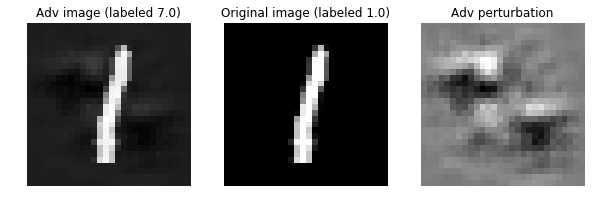

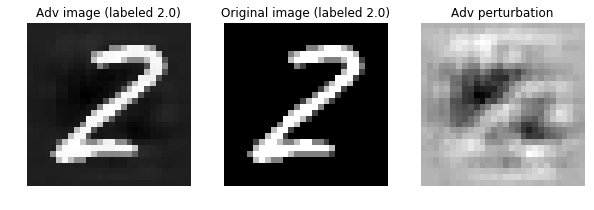

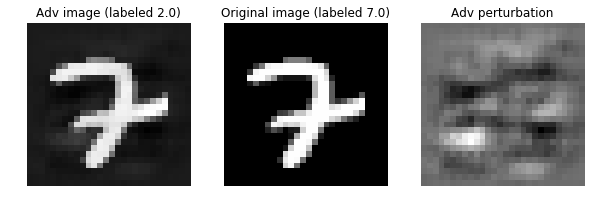

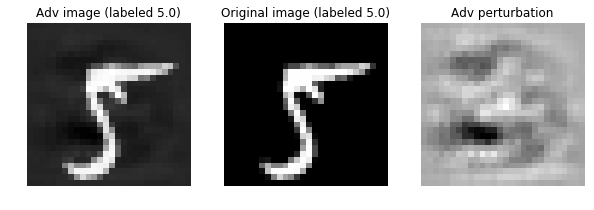

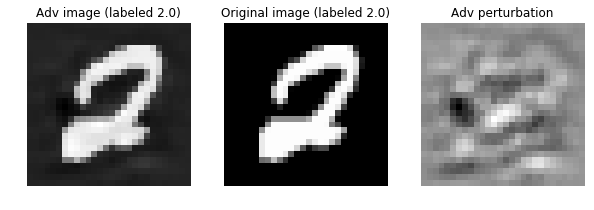

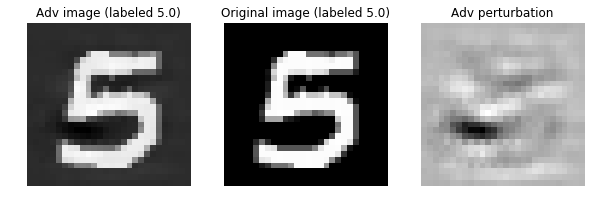

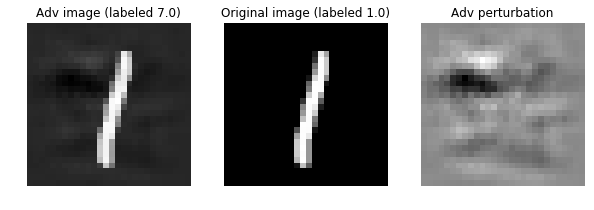

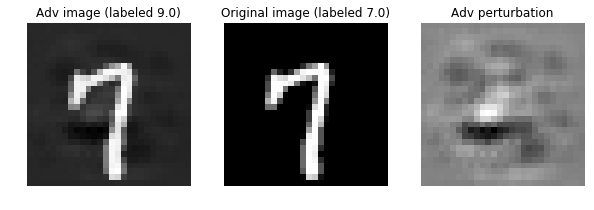

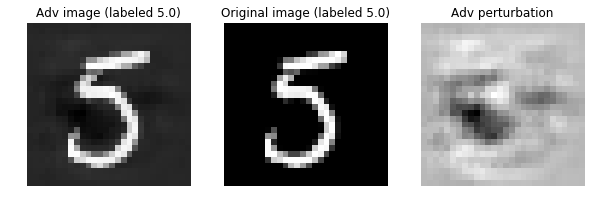

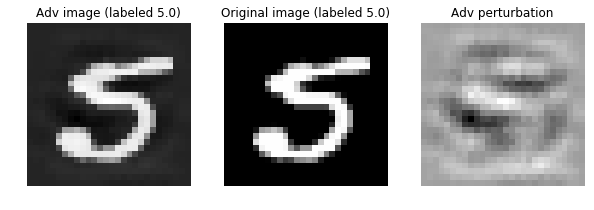

In [8]:
# Taking a closer look at some images

eps = 1.0
method = 'erm'
arch = model.elunet
save_dir = os.path.join('save_weights_final', 'mnist', method+'_debug')

X_test = Xtt[500:1000]

X_adv = ad.build_graph_and_gen_adv_examples(X_test, arch, save_dir, num_channels=1, method=ad.pgm, eps=eps, order=2)
Y_adv = dl_utils.build_graph_and_predict(X_adv, save_dir, arch, beta=1., num_channels=1)
Y_hat = dl_utils.build_graph_and_predict(X_test, save_dir, arch, beta=1., num_channels=1)

np.random.seed(0)
for i in np.random.choice(range(len(X_adv)), 10):

    x1 = X_adv[i].reshape(28, 28)
    x2 = X_test[i].reshape(28, 28)
    delta = x1-x2

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(x1, cmap='gray')
    plt.axis('off')
    plt.title('Adv image (labeled %s)'%(Y_adv[i]))
    plt.subplot(1, 3, 2)
    plt.imshow(x2, cmap='gray')
    plt.axis('off')
    plt.title('Original image (labeled %s)'%(Y_hat[i]))
    plt.subplot(1, 3, 3)
    plt.imshow(delta, cmap='gray')
    plt.title('Adv perturbation')
    plt.axis('off')
    plt.show()

# Testing spectral normalization

In [8]:
arch = model.elunet_sn

beta = 2.5
method = 'erm'

save_dir = os.path.join('save_weights_final', 'mnist', '%s_beta%s'%(method, beta)+'_test')
train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method, beta=beta)

Epoch 18/25 (53.653 s), batch 101/214 (1.245 s): loss 0.034, acc 0.988

KeyboardInterrupt: 